# ACADM
[Medium-chain acyl-CoA dehydrogenase deficiency (ACADMD)](https://omim.org/entry/201450) is caused by homozygous or compound heterozygous mutation in the medium-chain acyl-CoA dehydrogenase gene (ACADM).
Here we ingest a dataset reported in [Tucci S, et al. (2021) Genotype and residual enzyme activity in medium-chain acyl-CoA dehydrogenase (MCAD) deficiency: Are predictions possible? J Inherit Metab Dis.](https://pubmed.ncbi.nlm.nih.gov/33580884/). Limited clinical information is provided, but we can collect data on genotypes and enzyme activity to show how GPSEA can be used to perform tests of association of genotypes with numerical measurements using a t test.

The authors speak of 
> a severe mutation, c.985G>A (p.Lys329Glu), or a mild mutation, c.199T>C (p.Tyr67His).

We will perform t tests for both of thest variants.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.4


# ACADM
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ACADM.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'ACADM'
mane_tx_id = 'NM_000016.6'
mane_protein_id = 'NP_000007.1' # medium-chain specific acyl-CoA dehydrogenase, mitochondrial isoform a precursor

pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from gpsea.preprocessing import configure_caching_cohort_creator

cohort_name = gene_symbol

cohort_creator = configure_caching_cohort_creator(hpo)
from gpsea.preprocessing import load_phenopacket_folder
pp_dir = 'phenopackets/'
cohort, qc_results = load_phenopacket_folder(pp_dir, cohort_creator)  
qc_results.summarize()

Individuals Processed: 115 individuals [00:00, 2578.31 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer
viewer = CohortViewer(hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

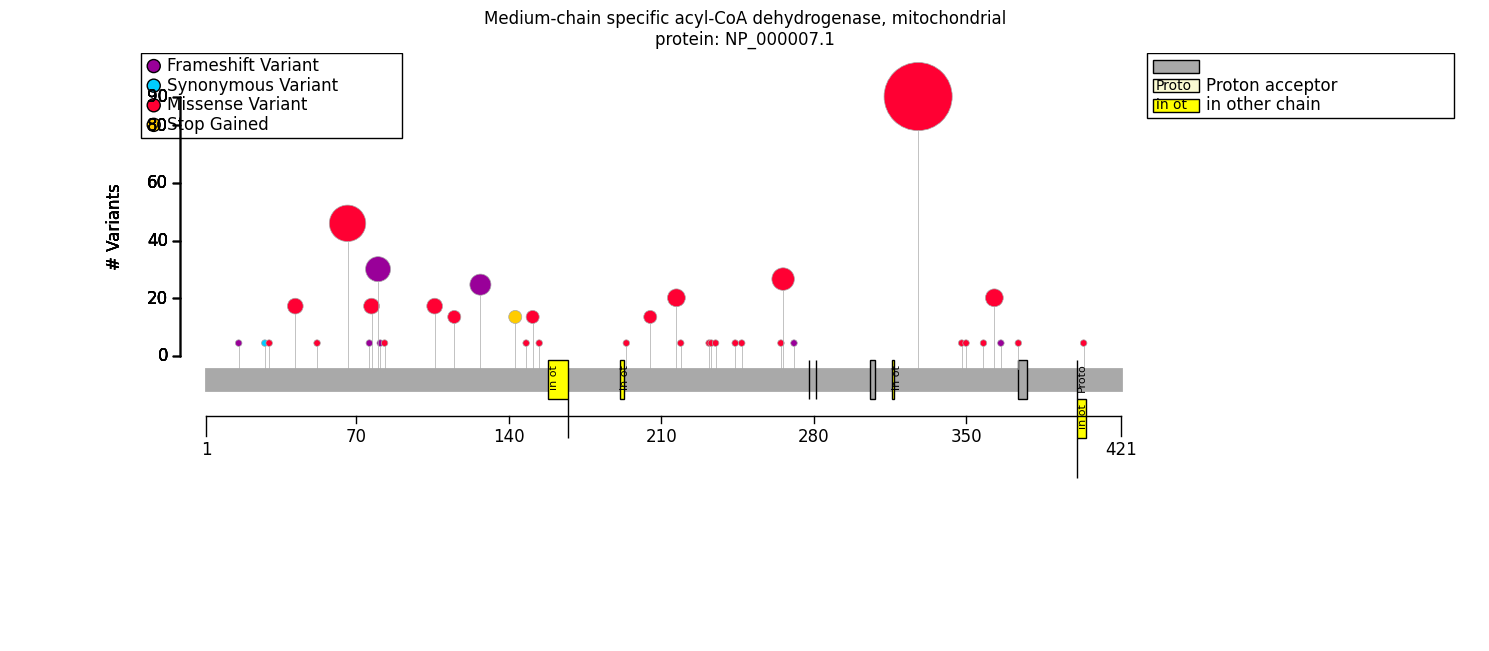

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

acadm_fig, acadm_ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=acadm_ax,
)
acadm_fig.tight_layout()

# Genotype-Phenotype Correlation  (GPC) Analysis

Following Tucci et al (see above), we will test the "severe" variant c.985G>A (p.Lys329Glu) and the "mild" variant, c.199T>C (p.Tyr67His) for correlation with MCAD activity using a t test. Our input data mainly included information about variants and enzyme activity, so there are the only two tests we will perform for this cohort.

In [6]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_key, variant_effect
from gpsea.analysis.clf import biallelic_classifier

is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

Lys329Glu = variant_key("1_75761161_75761161_A_G") # c.985A>G	p.Lys329Glu	
Tyr67His = variant_key("1_75732724_75732724_T_C") #c.199T>C	p.Tyr67His	

Lys329Glu_homozygote_clf = biallelic_classifier(
    a_predicate=Lys329Glu,
    b_predicate=~Lys329Glu,
    a_label="K329Q",
    b_label="other",
    partitions=((0,), (1,2))
)

Tyr67His_homoyzgote_or_ch_clf = biallelic_classifier(
    a_predicate=Tyr67His,
    b_predicate=~Tyr67His,
    a_label="Y67H",
    b_label="other",
    partitions=((0,1), (2,))
)

In [7]:
from gpsea.analysis.pscore import MeasurementPhenotypeScorer, PhenotypeScoreAnalysisResult
from gpsea.analysis.pscore.stats import TTestStatistic
from gpsea.analysis.pscore import PhenotypeScoreAnalysis
from gpsea.analysis.clf import GenotypeClassifier
from gpsea.model import Cohort

def perform_t_test(loinc_id: str,
                   loinc_label:str,
                   cohort: Cohort,
                   gt_clf: GenotypeClassifier) -> PhenotypeScoreAnalysisResult:
    pheno_scorer = MeasurementPhenotypeScorer.from_measurement_id(
        term_id=loinc_id,
        label=loinc_label
    )
    score_statistic = TTestStatistic()
    score_analysis = PhenotypeScoreAnalysis(
        score_statistic=score_statistic,
    )
    result = score_analysis.compare_genotype_vs_phenotype_score(
        cohort=cohort,
        gt_clf=gt_clf,
        pheno_scorer=pheno_scorer,
    )
    return result

# LOINC:74892-1: MCAD Activity (% of normal)
LOINC code [LOINC:74892-1](https://loinc.org/74892-1) specifies medium-chain acyl-CoA dehydrogenase (MCAD) activity. See [EC 1.3.8.7: medium-chain acyl-CoA dehydrogenase](https://www.brenda-enzymes.org/all_enzymes.php?ecno=1.3.8.7).

In [8]:
loinc_id ="LOINC:74892-1"
loinc_label = "MCAD Activity%"

# Lys329Glu
c.985G>A (p.Lys329Glu) is tthe severe mutation according to the authors.

Lys329Glu: t test for MCAD Activity%(LOINC:74892-1): 6.122643015760305e-10


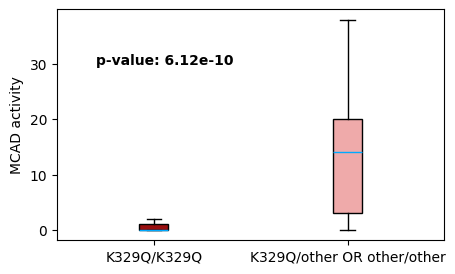

In [9]:
import matplotlib.pyplot as plt

result_Lys329Glu = perform_t_test(loinc_id=loinc_id, 
                                  loinc_label=loinc_label, 
                                  cohort=cohort, 
                                  gt_clf=Lys329Glu_homozygote_clf)
print(f"Lys329Glu: t test for {loinc_label}({loinc_id}): {result_Lys329Glu.pval}")

fig, ax = plt.subplots(figsize=(5, 3))
p_value_text = f'p-value: {result_Lys329Glu.pval:.2e}'
ax.text(0.7, 30, p_value_text, weight='bold')
ax.set_ylabel("MCAD activity")

result_Lys329Glu.plot_boxplots(ax=ax)


# Getting original data
We can access the original data from the GPSEA result object as follows. We use it here to calcualte the mean MCAD activity for each group, and create a string that we will use for the summary.

In [10]:
df = result_Lys329Glu.data
group0_mean = df[df["genotype"] == 0]["phenotype"].mean()
group1_mean = df[df["genotype"] == 1]["phenotype"].mean()
k329_interpretation = f"Mean MCAD activity for K329/K329: {group0_mean:.2f}%, and for K329/other or other/other: {group1_mean:.2f}%"
print(k329_interpretation)

Mean MCAD activity for K329/K329: 0.52%, and for K329/other or other/other: 13.23%


# Tyr67His
c.199T>C (p.Tyr67His) is a mild mutation according to the authors

Tyr67His: t test for MCAD Activity%(LOINC:74892-1): 2.0099847817662854e-05


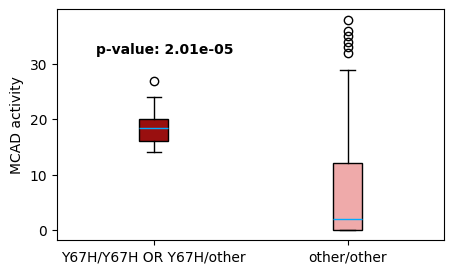

In [11]:
import matplotlib.pyplot as plt

result_Tyr67His = perform_t_test(loinc_id=loinc_id, 
                                 loinc_label=loinc_label, 
                                 cohort=cohort, 
                                 gt_clf=Tyr67His_homoyzgote_or_ch_clf)
print(f"Tyr67His: t test for {loinc_label}({loinc_id}): {result_Tyr67His.pval}")
fig, ax = plt.subplots(figsize=(5, 3))

p_value_text = f'p-value: {result_Tyr67His.pval:.2e}'
ax.text(0.7, 32, p_value_text, weight='bold')
ax.set_ylabel("MCAD activity")

result_Tyr67His.plot_boxplots(ax=ax)

In [12]:
df = result_Tyr67His.data
group0_mean = df[df["genotype"] == 0]["phenotype"].mean()
group1_mean = df[df["genotype"] == 1]["phenotype"].mean()
y67h_interpretation = f"Mean MCAD activity for Y67H/Y67H: {group0_mean:.2f}%, and for Y67H/other or other/other: {group1_mean:.2f}%"
print(y67h_interpretation)

Mean MCAD activity for Y67H/Y67H: 18.60%, and for Y67H/other or other/other: 7.68%


# Summary

In [13]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

M_results = (
    GPAnalysisResultSummary.from_mono(
        result=result_Lys329Glu,
        xrefs={
            'LOINC:74892-1': ('PMID:33580884'),
        },
        interpretation=k329_interpretation
    ),
    GPAnalysisResultSummary.from_mono(
        result=result_Tyr67His,
        xrefs={
            'LOINC:74892-1': ('PMID:33580884'),
        },
        interpretation=y67h_interpretation
    )
)

abcb7_caption = "No statistically significant results identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             mono_results=M_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=abcb7_caption)

In [14]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Description,Variable,Genotype (A),Genotype (B),p value
Value of MCAD Activity% [LOINC:74892-1],LOINC:74892-1,K329Q/K329Q,K329Q/other OR other/other,6.12e-10
Description,Variable,Genotype (A),Genotype (B),p value
Value of MCAD Activity% [LOINC:74892-1],LOINC:74892-1,Y67H/Y67H OR Y67H/other,other/other,2.01e-05


In [15]:
summarizer.process_latex(report=report, protein_fig=acadm_fig)

Figure saved to ../../supplement/img/ACADM_protein_diagram-draft.pdf
Output to ../../supplement/tex/ACADM_summary_draft.tex
